# 1. Set up

## 1.1 Environment

In [56]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from IPython.display import display
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib as mpl
import sklearn
import re

import statsmodels.api as sm 
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
sns.set_style('whitegrid')

from __future__ import division
from math import *
from scipy import integrate
from numpy import inf, pi
from sklearn.neighbors import KernelDensity
from sklearn import mixture

from windrose import WindroseAxes, WindAxes

from helpers.utility_helper import *
from helpers.app_helper import *
from helpers.gmm_helper import *
from helpers.plot_helper import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1.2 Read Data

In [57]:
ipath = './data/NCDC/boscombe_down/3466726903106dat.txt'
# ipath = './data/NCDC/ciampino/6240476818161dat.txt'
# ipath = './data/NCDC/tiree.txt'
# ipath= "./data/NCDC/marham.txt"
# ipath= "./data/NCDC/上海/虹桥/9705626661750dat.txt"
# ipath= "./data/NCDC/广州/白云/1032986661787dat.txt"
uipath = unicode(ipath , "utf8")

# If contains Chinese
if re.findall(ur'[\u4e00-\u9fff]+', uipath): 
    df = pd.read_csv(uipath, sep=' ', skipinitialspace=True, skiprows=[0])
    df.drop(['Dir', 'Spd'], 1,inplace=True)
    df.rename(columns={'QCP':'Dir','I.1':'Spd'}, inplace=True)
else:
    df = pd.read_csv(uipath,header=0, skipinitialspace=True)
df.rename(columns={'Date':'date','Dir':'dir','Spd':'speed','Type':'type'}, inplace=True)
df = df[['date','HrMn','type','dir','speed' ]]
df.describe()

,date,HrMn,dir,speed
count,511302.000000,511302.000000,511302.000000,511302.000000
mean,19966005.438352,1158.515552,236.408219,4.728720
std,150314.007385,683.360521,188.224879,5.189054
min,19310101.000000,0.000000,10.000000,0.000000
25%,19861014.000000,600.000000,140.000000,2.600000
50%,20001005.000000,1150.000000,220.000000,4.600000
75%,20081130.000000,1750.000000,290.000000,6.200000
max,20151201.000000,2350.000000,999.000000,999.900000


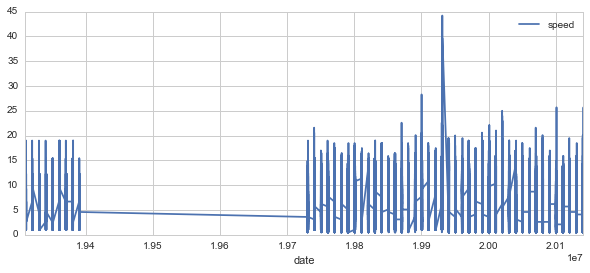

In [58]:
# select year 1945-2014, dir < 999, speed<999
df = df[(df['dir'] < 999) & (df['speed'] < 999)& (df['date'] < 20150000) ]
df.index= df['date']
df['speed'].plot(legend=True,figsize=(10,4), grid=True)

In [59]:
# Using speed unit in knot instead of m/s
# need more elaboration, some is not near an integer
if not re.findall(ur'[\u4e00-\u9fff]+', uipath): 
    df.rename(columns={'speed':'speed_mps'}, inplace=True)
    df['speed']=df['speed_mps']
    df['speed']=df['speed_mps']*1.943845
    df['speed']=df['speed'].apply(lambda x: int(round(x)))

In [60]:
# Turn dir into [0,360), some station are[10,360],some are [0,350]
df['dir'] = df['dir'].apply(lambda x: x%360)

In [61]:
# Data Selection
# Marham, date >1973
# Ciampino, date： 1973~2014
if "ciampino" not in ipath: 
    df = df[ (df['date'] > 19730000) & (df['date'] < 20150000)]
    df = df[(df['HrMn'] % 100 <= 0.1)]
#     df = df[(df['type'] == 'FM-12')]
#     df = df[(df['HrMn'] % 1200 == 0)]
else: 
    # For Roma Ciampino
    df = df[ (df['date'] > 19720000) & (df['date'] < 20150000)]
    df = df[(df['HrMn'] % 100 == 15)|(df['HrMn'] % 100 == 45)|(df['HrMn'] % 100 == 20)|(df['HrMn'] % 100 == 50)]

In [62]:
df.describe()

,date,HrMn,dir,speed_mps,speed
count,325110.000000,325110.000000,325110.000000,325110.000000,325110.000000
mean,19937773.617160,1158.501738,194.468088,4.956314,9.639411
std,124811.379859,685.225436,96.633492,2.628254,5.107431
min,19730101.000000,0.000000,0.000000,0.500000,1.000000
25%,19830103.000000,600.000000,120.000000,3.100000,6.000000
50%,19941104.000000,1200.000000,210.000000,4.600000,9.000000
75%,20050426.000000,1700.000000,280.000000,6.700000,13.000000
max,20141231.000000,2300.000000,350.000000,44.200000,86.000000


## 1.3 Data Wrangling

### 1.3.1 Artefacts handling

,date,HrMn,type,dir,speed_mps,speed,incre,incre_reverse
date,,,,,,,,
19931009,19931009,1800,FM-12,240,44.2,86,76,77
19931229,19931229,1800,FM-12,30,39.6,77,66,68
19930509,19930509,0,FM-12,240,35.0,68,55,53
20141216,20141216,1100,FM-12,110,25.7,50,47,44
20101111,20101111,700,FM-12,120,25.7,50,27,25
19900125,19900125,1200,FM-12,220,25.7,50,7,6
20020128,20020128,1400,FM-12,250,25.0,49,6,34
20020313,20020313,1700,FM-12,70,24.0,47,24,26
19900125,19900125,1600,FM-12,270,23.1,45,0,14


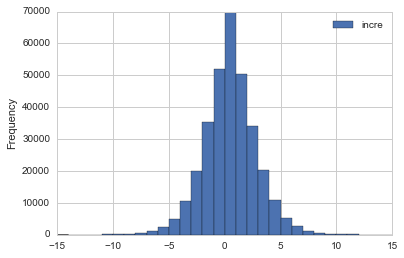

In [63]:
df['incre'] = df.speed.diff(1)
df['incre'].fillna(0)
df['incre_reverse'] = df.speed.diff(-1)
df['incre_reverse'].fillna(0)
display(df.sort_values(by='speed',ascending=False).head(10))
bins=np.arange(-15, 15 + 1, 1)
df['incre'].plot(kind='hist', bins=bins, legend=True)

In [64]:
# Simple Artefacts Handling
df =  df[ (df['incre'] < 20)&(df['incre_reverse'] < 20)]
df = df[df['dir'] % 10 <= 0.1]

After Simple Aretefacts Handling

In [65]:
# Check the max speed
df.sort_values(by='speed',ascending=False).head(10)

,date,HrMn,type,dir,speed_mps,speed,incre,incre_reverse
date,,,,,,,,
19900125,19900125,1200,FM-12,220,25.7,50,7,6
19900125,19900125,1600,FM-12,270,23.1,45,0,14
19900125,19900125,1400,FM-12,260,23.1,45,1,0
19870327,19870327,900,FM-12,220,22.6,44,2,2
19900125,19900125,1300,FM-12,230,22.6,44,-6,-1
19930113,19930113,1500,FM-12,210,22.6,44,4,8
19900125,19900125,1100,FM-12,230,22.1,43,8,-7
19931209,19931209,200,SY-MT,270,22.1,43,2,5
20070118,20070118,1500,FM-12,270,21.6,42,10,9


### 1.3.2 Sampling Equality, and Time Shift Comparison

1200    14145
1500    14141
1600    14093
1400    14085
1300    14083
1100    14061
1000    13954
1700    13871
900     13815
1800    13696
800     13598
1900    13551
2000    13468
2100    13365
700     13309
2300    13211
2200    13211
0       13197
100     13103
600     13085
300     13052
200     13049
500     12988
400     12953
Name: HrMn, dtype: int64

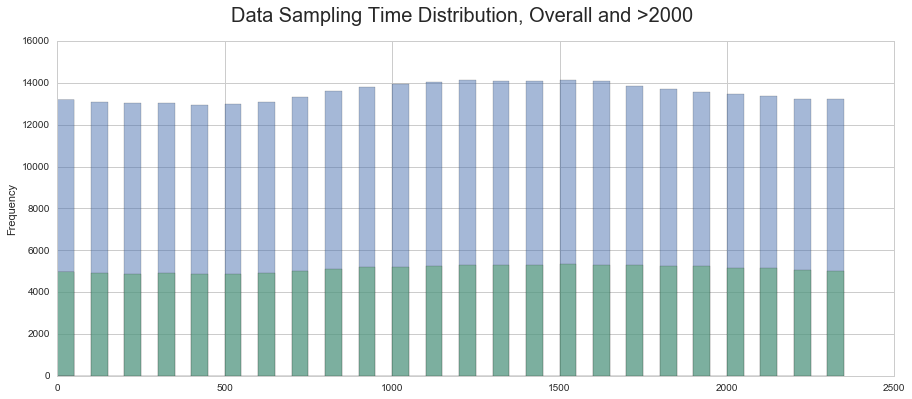

In [66]:
# Ensure data sampled equally
display(df['HrMn'].value_counts())
bins=np.arange(min(df.HrMn), max(df.HrMn) + 100, 50)
df['HrMn'].hist(bins=bins, alpha=0.5,figsize=(15, 6))

df_temp = df[df['date'] > 20000000]
df_temp['HrMn'].plot(kind='hist', alpha=0.5,figsize=(15, 6),bins=bins)

plt.suptitle('Data Sampling Time Distribution, Overall and >2000', fontsize = 20)

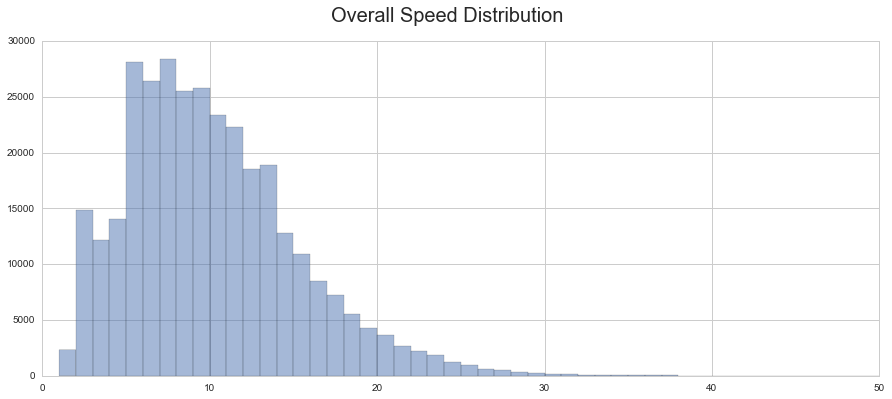

In [67]:
bins=np.arange(min(df.speed), max(df.speed) + 1, 1)
df['speed'].hist(bins=bins, alpha=0.5,figsize=(15, 6))
plt.suptitle('Overall Speed Distribution', fontsize = 20)

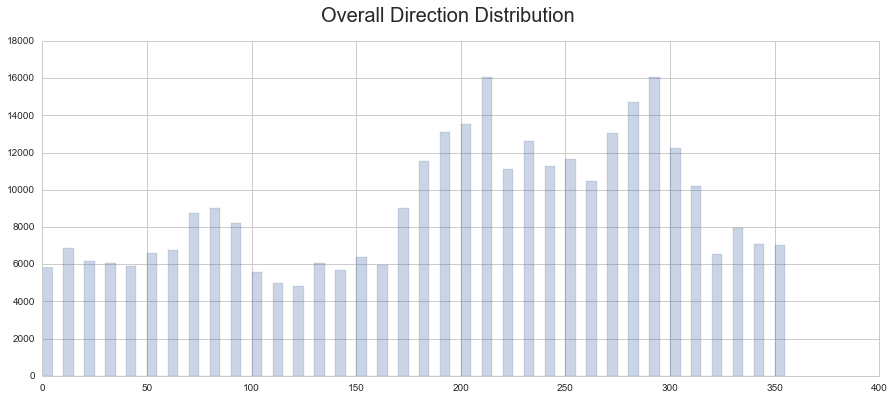

In [68]:
bins=np.arange(min(df.dir), max(df.dir) + 10, 5)
df['dir'].hist(bins=bins, alpha=0.3,figsize=(15, 6))
plt.suptitle('Overall Direction Distribution', fontsize = 20)

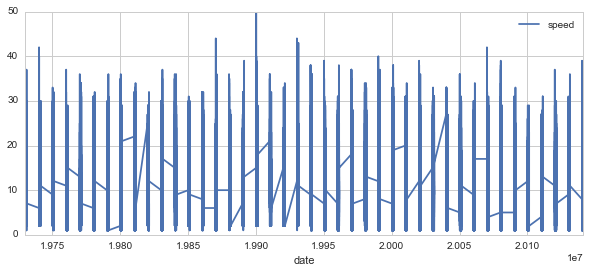

In [69]:
df['speed'].plot(legend=True,figsize=(10,4), grid=True)

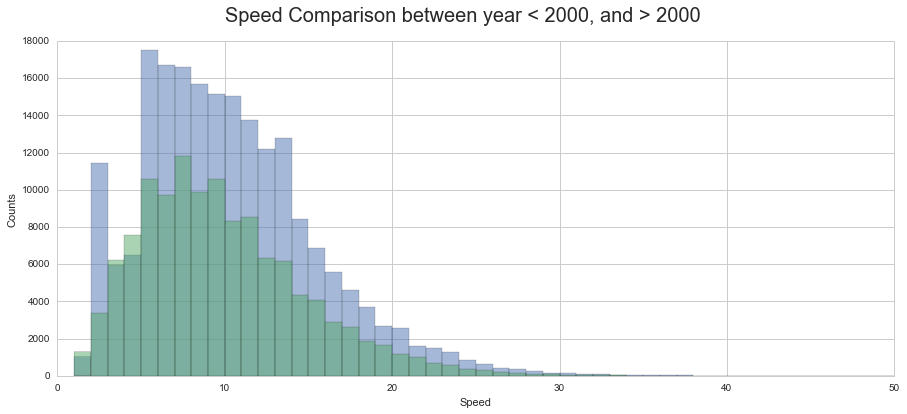

In [70]:
# Comparison between year < 2000, and > 2000, looking for: 
# 1. Odd Even Bias
# 2. Time Shift of Wind Speed Distribution
bins = np.arange(min(df.speed), max(df.speed) + 1, 1)
df_temp = df[df['date'] < 20000000]
df_temp['speed'].hist(bins=bins,alpha = 0.5,figsize=(15, 6))

df_temp = df[df['date'] > 20000000]
df_temp['speed'].hist(bins=bins, alpha = 0.5,figsize=(15, 6))

plt.xlabel("Speed")
plt.ylabel("Counts")
plt.suptitle('Speed Comparison between year < 2000, and > 2000', fontsize = 20)

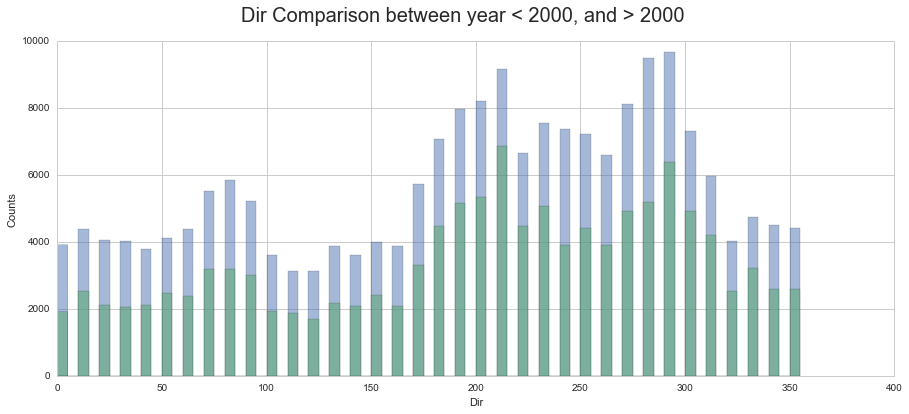

In [71]:
bins=np.arange(min(df.dir), max(df.dir) + 10, 5)
df_temp = df[df['date'] < 20000000]
df_temp['dir'].hist(bins=bins, alpha=0.5,figsize=(15, 6))

df_temp = df[df['date'] > 20000000]
df_temp['dir'].hist(bins=bins, alpha=0.5,figsize=(15, 6))

plt.xlabel("Dir")
plt.ylabel("Counts")
plt.suptitle('Dir Comparison between year < 2000, and > 2000', fontsize = 20)

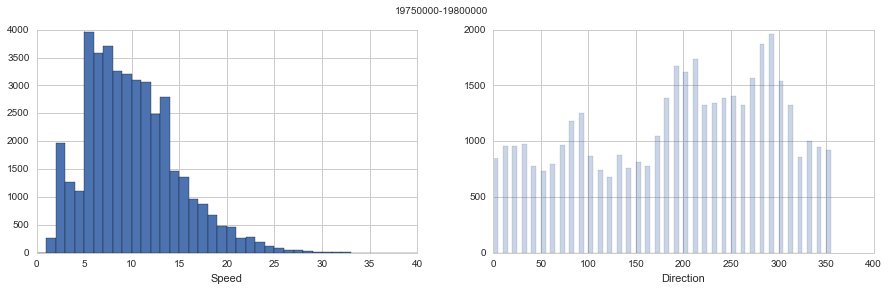

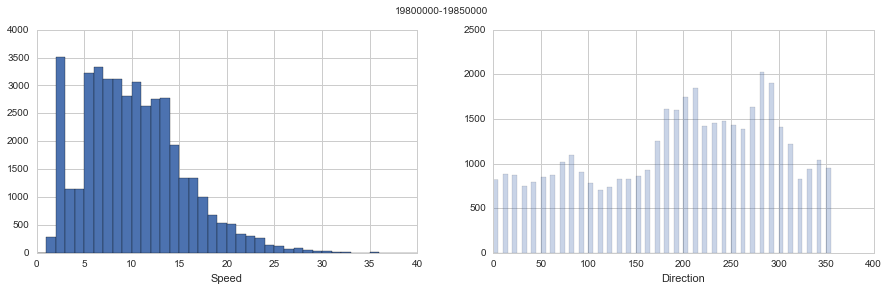

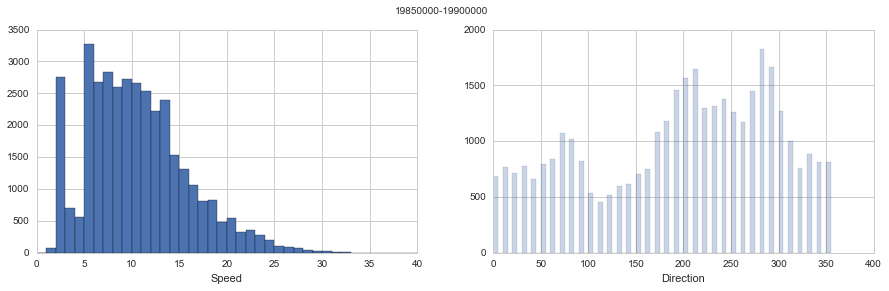

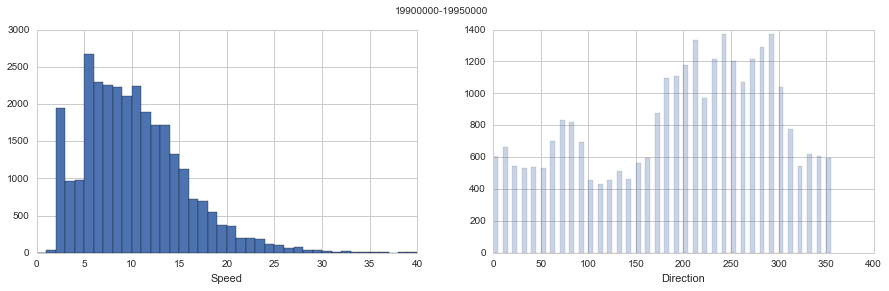

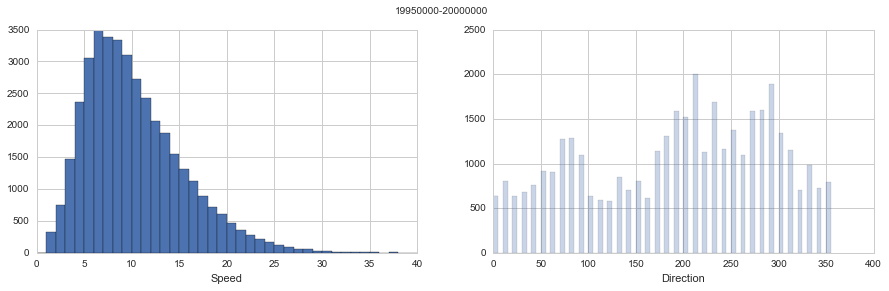

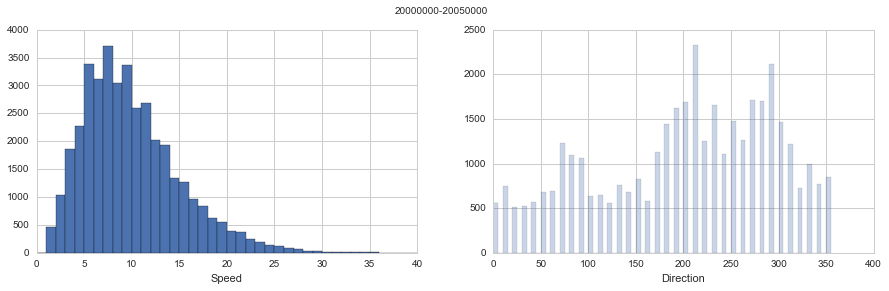

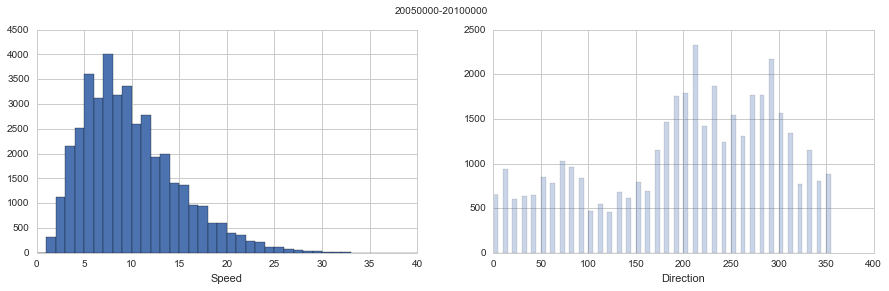

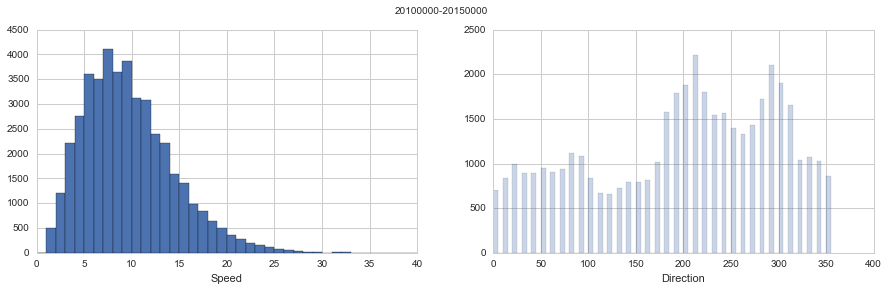

In [72]:
# Inspect the time shift of speed and degree distribution, and odd-even bias
def check_time_shift(df):
    for start_time in xrange(19750000,20150000,50000):
        end_time = start_time + 50000 
        sub_df = df[ (df['date'] >= start_time) & (df['date'] < end_time)]
        title = str(start_time) +'-' + str(end_time)
        plot_speed_and_angle_distribution(sub_df, title)
        plt.show()
        
check_time_shift(df)

## 1.4 Re-select time range, Data Conversion, and overview of the clean dataset

In [73]:
# if "ciampino" in ipath: 
#     # For Ciampino
#     df = df[ (df['date'] >= 19950000) & (df['date'] < 20150000)]
# elif "marham" in ipath:
#     # speed still suffers from odd-even bias
#     df = df[ (df['date'] >= 19950000) & (df['date'] < 20150000)]
# elif "boscombe" in ipath:
#     # speed still suffers from odd-even bias
#     df = df[ (df['date'] >= 20100000) & (df['date'] < 20150000)]
# else: 
#     # For Tiree, non is stable
#     df = df[ (df['date'] >= 20050000) & (df['date'] < 20150000)]
    
df = df[ (df['date'] >= 20100000) & (df['date'] < 20150000)]

### 1.4.1 Overview

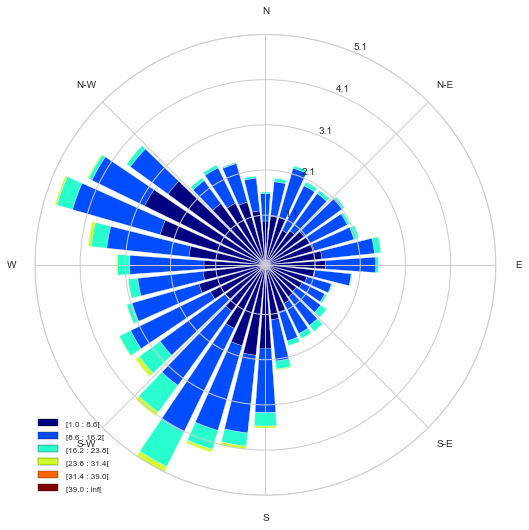

In [74]:
df.dir_windrose = df.dir
# 90 degree is in east
ax = WindroseAxes.from_ax()
ax.bar(df.dir_windrose, df.speed, normed=True, opening=0.8, edgecolor='white', nsector=36)
ax.set_legend()

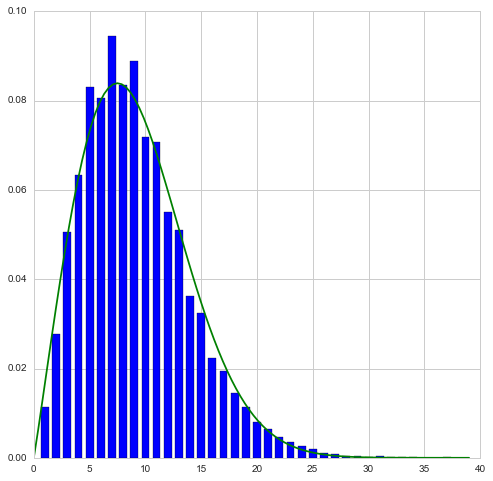

In [75]:
ax = WindAxes.from_ax()
bins=np.arange(min(df.speed), max(df.speed) + 1, 1)
ax, params = ax.pdf(df.speed, bins = bins)

In [76]:
print params
weibull_params = sp.stats.exponweib.fit(df.speed, floc=0, f0=1)
print weibull_params

(1, 2.0498153372499339, 0, 10.389837898638376)
(1, 2.0498153372499339, 0, 10.389837898638376)


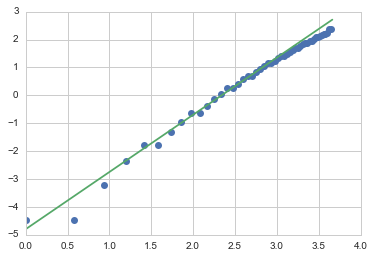

In [77]:
sample = df.speed
ecdf = sm.distributions.ECDF(sample)

x = np.linspace(min(sample), max(sample))
y = ecdf(x)
plt.plot(np.log(x), np.log(-np.log(1-y)),'o')

x = np.linspace(min(sample), max(sample))
w_scale = weibull_params[1]
c_shape = weibull_params[3]
qz=np.exp(-(x/c_shape)**w_scale)
plt.plot(np.log(x), np.log(-np.log(qz)),'-')
plt.show()

### 1.4.2 Direction Conversion, from windrose to polar system
e.g. 0 degree = north, clockwise => 90 degree = north, counterclockwise

In [78]:
df['dir'] = df['dir'].apply(lambda x: (90 - x)%360)

In [79]:
df['dir'].value_counts().sort_index()

0      1089
10     1120
20      939
30      904
40      945
50      889
60      891
70      994
80      838
90      702
100     859
110    1027
120    1073
130    1039
140    1655
150    1906
160    2108
170    1719
180    1435
190    1332
200    1393
210    1571
220    1549
230    1799
240    2219
250    1878
260    1789
270    1572
280    1020
290     812
300     796
310     796
320     729
330     659
340     672
350     839
Name: dir, dtype: int64

### 1.4.3 Re-distribute Direction, within each sector (optional)
e.g. Dir 50 -> -45 ~ 55, to make KDE result better

In [80]:
def randomize_angle(df):
    df['dir_ran'] = df['dir'].apply(lambda x: (x + np.random.uniform(-5,5))% 360)

    bins=np.arange(0, 360+10, 5)
    df['dir'].hist(bins=bins, alpha=0.5,figsize=(15, 6))
    bins=np.arange(0, 360+10, 1)
    df['dir_ran'].hist(bins=bins, alpha=0.5,figsize=(15, 6))
    
    df['dir']=df['dir_ran']
    df.drop(['dir_ran'], 1,inplace=True)
    return df

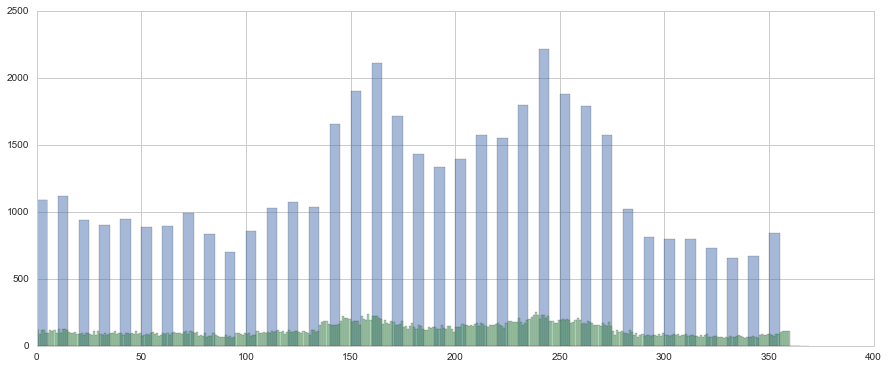

In [81]:
# Randomize the angle degree, to form a better KDE estimation
df['dir_int'] = df['dir']
df = randomize_angle(df)

### 1.4.4 Generate (x,y) from (speed,dir)

-1.92090538202 -1.23184002944


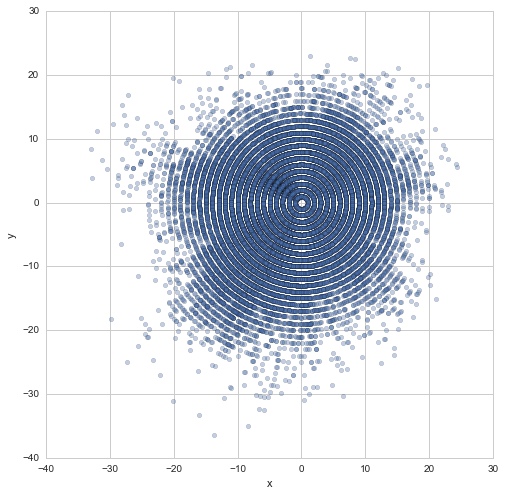

In [82]:
df['x'] = df['speed'] * np.cos(df['dir'] * pi / 180.0)
df['y'] = df['speed'] * np.sin(df['dir'] * pi / 180.0)
fig, ax = plt.subplots(figsize=(8, 8), dpi=80)
ax.set_aspect('equal')
df.plot(kind='scatter', x='x', y='y', alpha=0.35, ax=ax)
print np.mean(df.x), np.mean(df.y)

# 2. Create input data, i.e. speed_set

In [83]:
# speed_set = np.array(zip(-df.x, -df.y)) # Adjust the direction to match for Cook's paper
speed_set = np.array(zip(df.x, df.y))
speed_angle_set = np.array(zip(df.speed, df.dir))
number_of_gaussian = 3

In [84]:
fitting_range = []
for i in np.arange(-20, 21, 1):
    for j in np.arange(-20, 21, 1):
        fitting_range.append([i,j])

# 3. Kernel Density Estimation

In [85]:
sample = speed_set
kde = KernelDensity(bandwidth=1).fit(sample) # need to consider the bandwidth for different sites

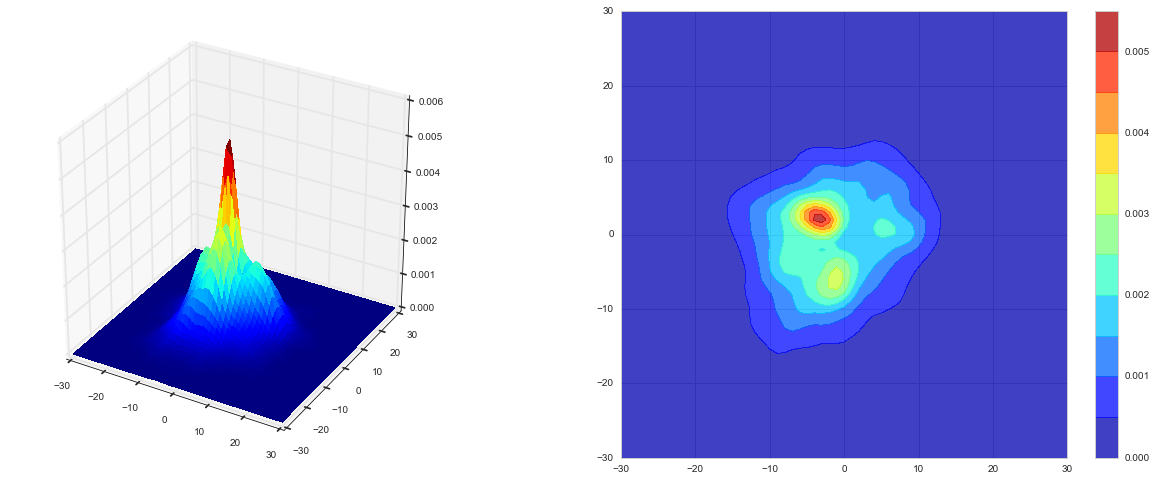

In [86]:
# Plot jPDF
X = Y = np.arange(-30, 31, 1)
# Can't work if pass as generate_Z_from_X_Y(X,Y, np.exp(kde.score_samples())), need to use lambda
# see http://stackoverflow.com/questions/21035437/passing-a-function-as-an-argument-in-python
Z = generate_Z_from_X_Y(X,Y, lambda coords: np.exp(kde.score_samples(coords)))

fig = plt.figure(figsize=(22,8))
ax1 = fig.add_subplot(1,2,1, projection = '3d')
plot_3d_prob_density(X,Y,Z,ax1)
ax2 = fig.add_subplot(1,2,2)
plot_2d_prob_density(X,Y,Z,ax2)

# 4. GMM Estimation, using EM algo

In [87]:
sample= speed_set

# fit a Gaussian Mixture Model with two components
clf = mixture.GMM(n_components=number_of_gaussian, covariance_type='full')
clf.fit(sample)

print clf.converged_

for i in xrange(clf.n_components):
    print clf.weights_[i], clf.means_[i], clf.covars_[i]

True
0.327658986654 [-3.40072514 -6.97314826] [[ 37.30647873   6.4457188 ]
 [  6.4457188   41.54279442]]
0.357777687491 [-5.32181279  1.76785492] [[ 36.18310883   2.28620033]
 [  2.28620033  28.11485142]]
0.314563325855 [ 3.48864141  1.33669625] [[ 35.00718023   1.79868044]
 [  1.79868044  36.87006328]]


In [88]:
gmm_em_result = read_gmm_em_result(clf)

GMM EM Result:
(0.32765898665395571, -3.400725136987161, -6.973148257817874, 6.1079029728369756, 6.4453699985844288, 0.16373117262106224)
(0.3577776874914349, -5.321812794584298, 1.7678549165408675, 6.0152397147046353, 5.3023439555265783, 0.071679249052249719)
(0.31456332585461005, 3.4886414116449194, 1.3366962518671732, 5.9166865918937548, 6.0720724036723688, 0.050065494040504456)


GMM Plot Result
0.327658986654 [[-3.40072514 -6.97314826]] [ 5.71312604  6.79775434] 144.095641272
0.357777687491 [[-5.32181279  1.76785492]] [ 5.24519524  6.06513702] -75.2295657483
0.314563325855 [[ 3.48864141  1.33669625]] [ 5.82349347  6.1615069 ] 148.688625432


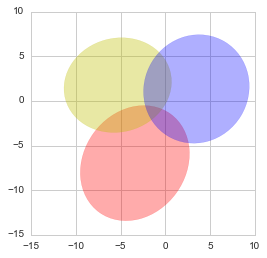

In [89]:
plot_gmm_ellipses(gmm_em_result)

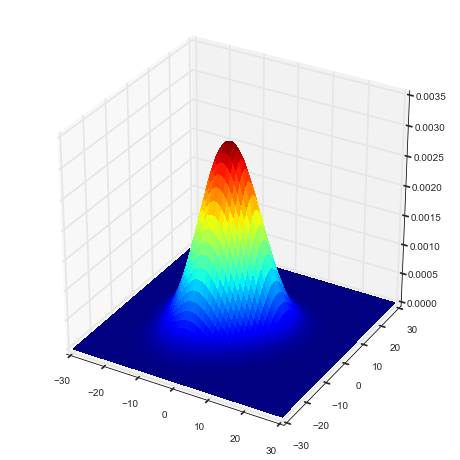

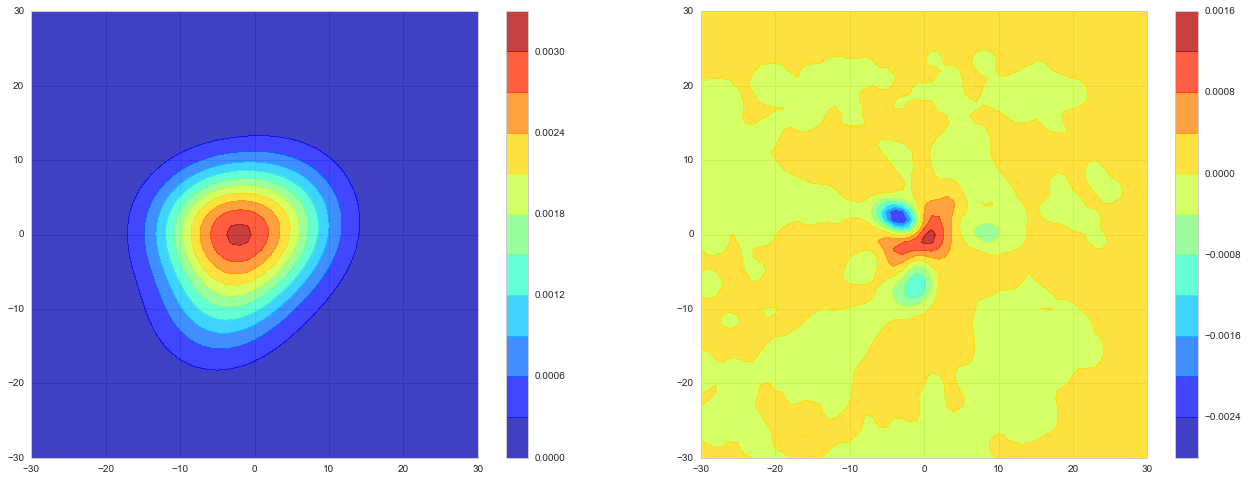

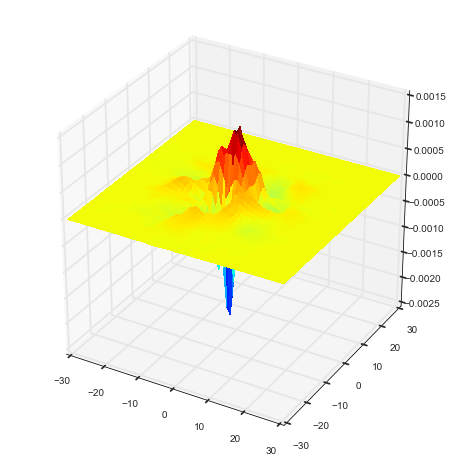

In [90]:
X = Y = np.arange(-30, 31, 1)
Z = generate_Z_from_X_Y(X,Y, lambda coords: np.exp(clf.score_samples(coords)[0]))
plot_3d_prob_density(X,Y,Z)

fig = plt.figure(figsize=(22,8))
ax1 = fig.add_subplot(1,2,1)
plot_2d_prob_density(X,Y,Z,ax1)

def residule_between_kde_and_gmm(points):
    kde_vals = np.exp(kde.score_samples(points))
    gmm_vals = np.exp(clf.score_samples(points)[0])
    return gmm_vals - kde_vals

Z = generate_Z_from_X_Y(X,Y, residule_between_kde_and_gmm)
ax2 = fig.add_subplot(1,2,2)
plot_2d_prob_density(X,Y,Z,ax2)
plot_3d_prob_density(X,Y,Z)

## GMM, EM VS. KDE

In [91]:
points = fitting_range
gmm_pdf_result = np.exp(clf.score_samples(points)[0])
kde_result = np.exp(kde.score_samples(points))

### RMSE & R Square

In [92]:
error_array = np.power(gmm_pdf_result - kde_result,2)
MSE = np.average(error_array)
RMSE = np.sqrt(MSE)

print RMSE
R_square_of(MSE, kde_result)

0.000244446007098


0.9067712042286441

# 5. Least Square Prob Estimation

In [93]:
if not 'kde' in globals():
    sample = speed_set
    kde = KernelDensity(bandwidth=1.0).fit(sample)

In [123]:
points = fitting_range
original_dim = int(np.sqrt(len(fitting_range)))

In [95]:
# very slow if the dataset is too large, e.g. 100,000
# kde returns log prob, need to convert it
kde_result = np.exp(kde.score_samples(points))
print kde_result
print len(kde_result)

[  1.14446078e-05   2.11231001e-05   3.25317243e-05 ...,   4.09495139e-06
   3.96619164e-06   1.45283478e-06]
1681


In [96]:
gmm_em_result = read_gmm_em_result(clf)

GMM EM Result:
(0.32765898665395571, -3.400725136987161, -6.973148257817874, 6.1079029728369756, 6.4453699985844288, 0.16373117262106224)
(0.3577776874914349, -5.321812794584298, 1.7678549165408675, 6.0152397147046353, 5.3023439555265783, 0.071679249052249719)
(0.31456332585461005, 3.4886414116449194, 1.3366962518671732, 5.9166865918937548, 6.0720724036723688, 0.050065494040504456)


In [124]:
def cdf_from_pdf(pdf):
    new_array = np.copy(pdf)
    xdim, ydim = new_array.shape
    for i in xrange(1,xdim):
         new_array[i,0] =  new_array[i-1,0] +  new_array[i,0]
    for i in xrange(1,ydim):
         new_array[0,i] =  new_array[0,i-1] +  new_array[0,i]
    for j in xrange(1,ydim):
        for i in xrange(1,xdim):
             new_array[i,j] =  new_array[i-1,j] +  new_array[i,j-1] -  new_array[i-1,j-1] + new_array[i,j]
    return new_array

kde_cdf = cdf_from_pdf(kde_result.reshape(original_dim,original_dim))

In [98]:
count = len(df)
def GMM_fit_score(gmm, kde_result, method = 'square_error'): 
    # 1. Create the GMM PDF
    if not isinstance(gmm[0], np.ndarray):
        gmm = group_gmm_param_from_gmm_param_array(gmm, sort_group = False)
    mixed_model_pdf = generate_gmm_pdf_from_grouped_gmm_param(gmm)
    # 2. Calculate the sum of square error
    gmm_pdf_result = mixed_model_pdf(points)
    if method == 'square_error':
        # 2.1 Square error
        error_array = np.power(gmm_pdf_result - kde_result,2)
        result = mse_log = np.log(np.average(error_array))
    elif method == 'chi_square':
        # 2.2 Chi square
        error_array = np.power(gmm_pdf_result - kde_result,2)
        # unable to * count = 43412
        result = chi_square_stat = sum(error_array/gmm_pdf_result) 
    elif method == 'K_S':
        # 2.3 K-S statistc
        gmm_cdf = cdf_from_pdf(gmm_pdf_result.reshape(original_dim,original_dim))
        diff = gmm_cdf - kde_cdf
        result = KS_stat = np.amax(diff)
    return result

# from GMM,EM 
# GMM format: weight, meanx, meany, sigx, sigy, rho
x0 = gmm_em_result

cons = [
    # sum of every 6th element, which is the fraction of each gaussian
    {'type': 'eq', 'fun': lambda x: sum(x[::6]) - 1},
    # limit the width/height ratio of elliplse, optional
    {'type': 'ineq', 'fun': lambda x: width_height_ratios_set(x) - 1/3},
    {'type': 'ineq', 'fun': lambda x: 3 - width_height_ratios_set(x)},]

bonds = [(0., 0.99),(-30, 30),(-30, 30),(0., 30),(0., 30),(-0.99, 0.99)]*int(len(x0)/6)

result = sp.optimize.minimize(
    lambda x0: GMM_fit_score(x0, kde_result),
    x0,
    bounds = bonds,
    constraints=cons,
    tol = 0.000000000001,
    options = {"maxiter": 500})
result

     fun: -17.665511782154315
     jac: array([  4.60712910e-02,   2.38418579e-07,   4.76837158e-07,
        -2.38418579e-07,   0.00000000e+00,   4.76837158e-07,
         4.60884571e-02,   2.38418579e-07,   0.00000000e+00,
        -4.76837158e-07,   0.00000000e+00,  -4.76837158e-07,
         4.60748672e-02,  -2.38418579e-07,   0.00000000e+00,
         0.00000000e+00,  -2.38418579e-07,   0.00000000e+00,
         0.00000000e+00])
 message: 'Optimization terminated successfully.'
    nfev: 1347
     nit: 67
    njev: 67
  status: 0
 success: True
       x: array([ 0.75377413, -3.78205992, -2.64154029,  6.14536009,  7.38979365,
       -0.09760025,  0.05712051, -3.61084194,  2.63667474,  1.9456908 ,
        1.44482845, -0.142475  ,  0.18910536,  6.42993911,  3.44382251,
        4.3820708 ,  5.45569015, -0.36750799])

## Goodness-of-fit indicators

In [134]:
def goodness_of_fit_summary(gmm_pdf_result, kde_result, count):
    error_array = np.power(gmm_pdf_result - kde_result,2)
    MSE = np.average(error_array)
    R_square = R_square_of(MSE, kde_result)
    Chi_square = sum(error_array/gmm_pdf_result) * count

    RMSE = np.sqrt(MSE)

    gmm_cdf = cdf_from_pdf(gmm_pdf_result.reshape(original_dim,original_dim))
    diff = gmm_cdf - kde_cdf
    KS_stat = np.amax(diff)

    return {
        'MSE': MSE,
        'R_square': R_square,
        'Chi_square': Chi_square,
        'K_S': KS_stat,
        'RMSE / Max': RMSE/np.max(kde_result),
        'RMSE / Mean': RMSE/np.mean(kde_result),
    }

goodness_of_fit_summary(gmm_pdf_result, kde_result, count = len(df))

{'Chi_square': 2755.9253940593567,
 'K_S': 0.026664664549659323,
 'MSE': 5.975385038629036e-08,
 'RMSE / Mean': 0.41582299183232713,
 'RMSE / Mode': 0.045843161380400239,
 'R_square': 0.9067712042286441}

## LRMSE VS. KDE

In [100]:
kde_result

array([  1.14446078e-05,   2.11231001e-05,   3.25317243e-05, ...,
         4.09495139e-06,   3.96619164e-06,   1.45283478e-06])

In [101]:
import pprint
pp = pprint.PrettyPrinter()

gmm = group_gmm_param_from_gmm_param_array(result.x, sort_group = True)
pp.pprint(gmm)

[array([ 0.75377413, -3.78205992, -2.64154029,  6.14536009,  7.38979365,
       -0.09760025]),
 array([ 0.18910536,  6.42993911,  3.44382251,  4.3820708 ,  5.45569015,
       -0.36750799]),
 array([ 0.05712051, -3.61084194,  2.63667474,  1.9456908 ,  1.44482845,
       -0.142475  ])]


GMM Plot Result
0.753774133788 [[-3.78205992 -2.64154029]] [ 6.05560167  7.46352392] -166.121293208
0.18910535579 [[ 6.42993911  3.44382251]] [ 3.77259566  5.89360853] -150.504280906
0.0571205104221 [[-3.61084194  2.63667474]] [ 1.41343712  1.96861308] -102.626837395


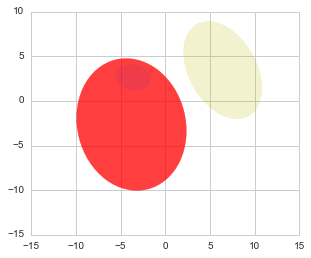

In [102]:
plot_gmm_ellipses(gmm)

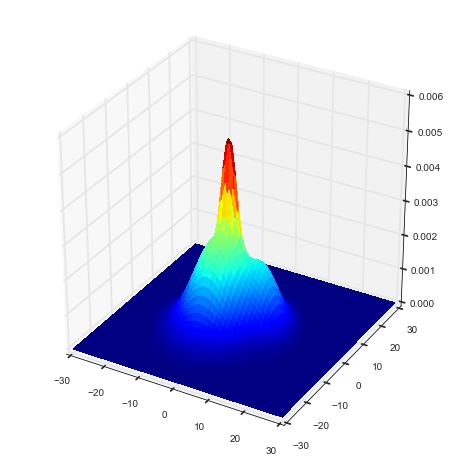

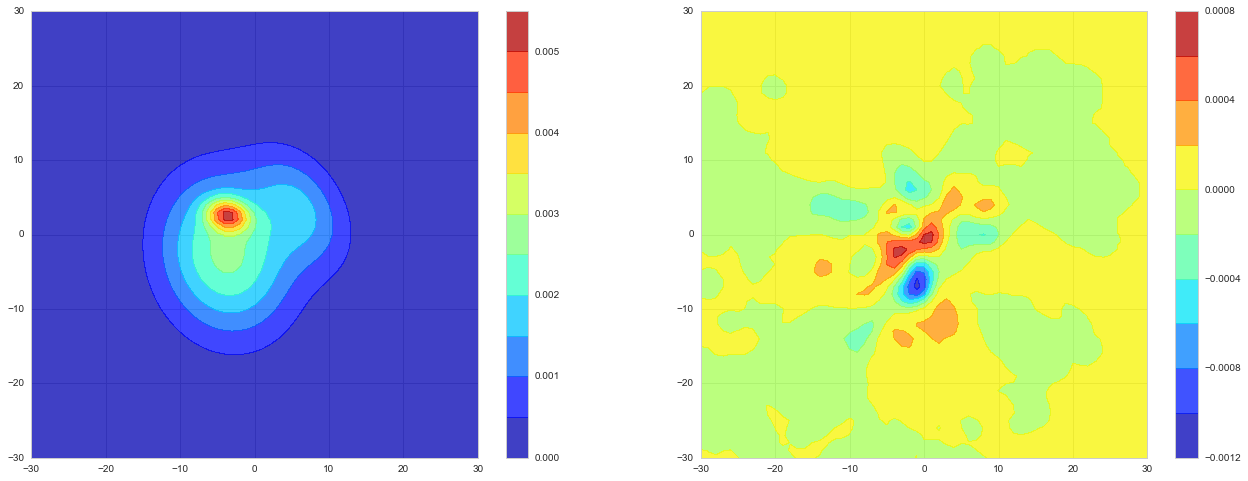

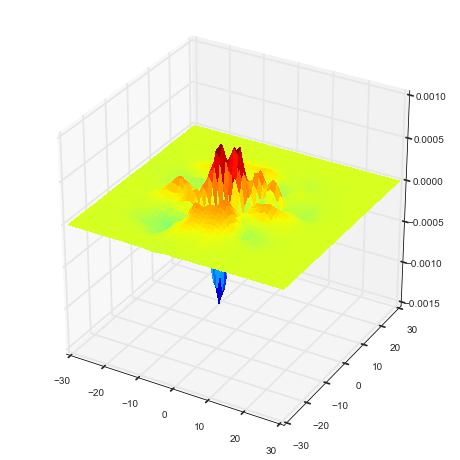

In [103]:
mixed_model_pdf = generate_gmm_pdf_from_grouped_gmm_param(gmm)

X = Y = np.arange(-30, 31, 1)
Z = generate_Z_from_X_Y(X,Y, mixed_model_pdf)# passing a function as an argument
plot_3d_prob_density(X,Y,Z)

fig = plt.figure(figsize=(22,8))
ax1 = fig.add_subplot(1,2,1)
plot_2d_prob_density(X,Y,Z,ax1)

def residule_between_kde_and_gmm(points):
    kde_vals = np.exp(kde.score_samples(points))
    gmm_vals = mixed_model_pdf(points)
    return gmm_vals - kde_vals

Z = generate_Z_from_X_Y(X,Y, residule_between_kde_and_gmm)
ax2 = fig.add_subplot(1,2,2)
plot_2d_prob_density(X,Y,Z,ax2)
plot_3d_prob_density(X,Y,Z)

In [104]:
def f(V,theta):
    return (mixed_model_pdf([[V*cos(theta),V*sin(theta)]]))*V

x_vals_OEN3_LMSE  = np.linspace(0,50)
y_vals_OEN3_LMSE =[integrate.nquad(f, [[0, x_val],[0, 2*np.pi]]) for x_val in x_vals_OEN3_LMSE ]

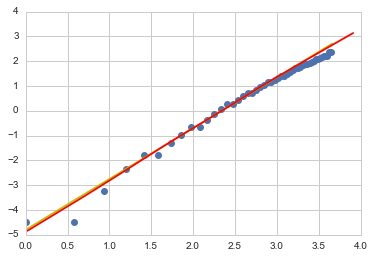

In [105]:
# Plot v-p points, empirical distribution
sample = df.speed
ecdf = sm.distributions.ECDF(sample)
x = np.linspace(min(sample), max(sample))
y = ecdf(x)
plt.plot(np.log(x), np.log(-np.log(1-y)),'o')

# Weibull distribution
x = np.linspace(min(sample), max(sample))
w_scale = weibull_params[1]
c_shape = weibull_params[3]
qz=np.exp(-(x/c_shape)**w_scale)
plt.plot(np.log(x), np.log(-np.log(qz)),'-', color = 'y')

# OEN3 distribution, LMSE
x, y_ = x_vals_OEN3_LMSE, y_vals_OEN3_LMSE
y = np.array(zip(*y_)[0])
plt.plot(np.log(x), np.log(-np.log(1-y)),'-', color = 'r')

plt.show()

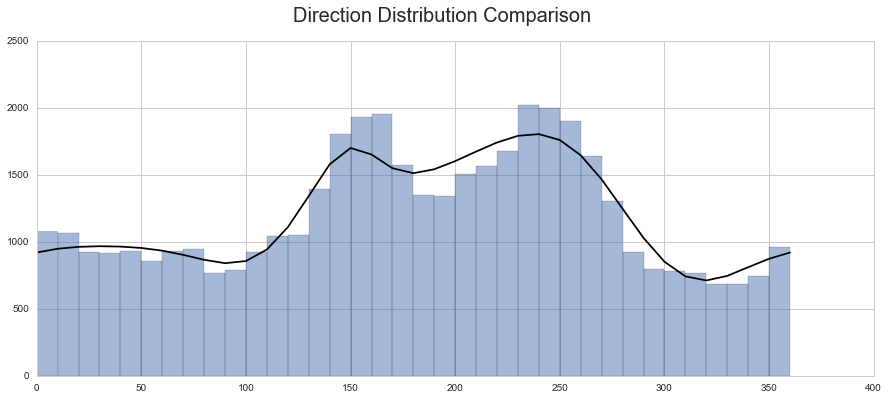

In [106]:
# Calculate Angle Distribution
x_vals = np.linspace(0,2*np.pi, num=36+1)
y_vals_ =[integrate.nquad(f, [[0, inf],[x_val-np.pi/36, x_val+np.pi/36]]) for x_val in x_vals]

# 1. integrate.nquad returns 2 vaule, result, abserr. Need to abstract the first to plot
# 2. * length of data size, to adjust the plot space
y_vals = np.array(zip(*y_vals_)[0])*len(df['dir']) 

bins=np.arange(0, 360 + 1, 10)
df['dir'].hist(bins=bins, alpha=0.5,figsize=(15, 6))

plt.plot(x_vals/np.pi*180, y_vals,'-', color='black')
plt.suptitle('Direction Distribution Comparison', fontsize = 20)
plt.show()

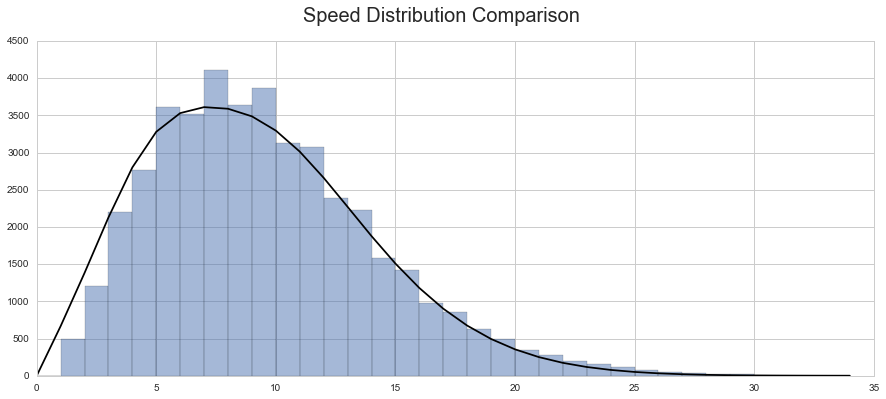

In [107]:
# Calculate Speed Distribution
x_vals = np.arange(0, 35, 1)
y_vals_ =[integrate.nquad(f, [[x_val-0.5, x_val+0.5],[0, 2*np.pi]]) for x_val in x_vals]
y_vals = np.array(zip(*y_vals_)[0])*len(df.speed)

df['speed'].hist(bins=x_vals, alpha=0.5,figsize=(15, 6))

plt.plot(x_vals, y_vals,'-', color='black')
plt.suptitle('Speed Distribution Comparison', fontsize = 20)
plt.show()

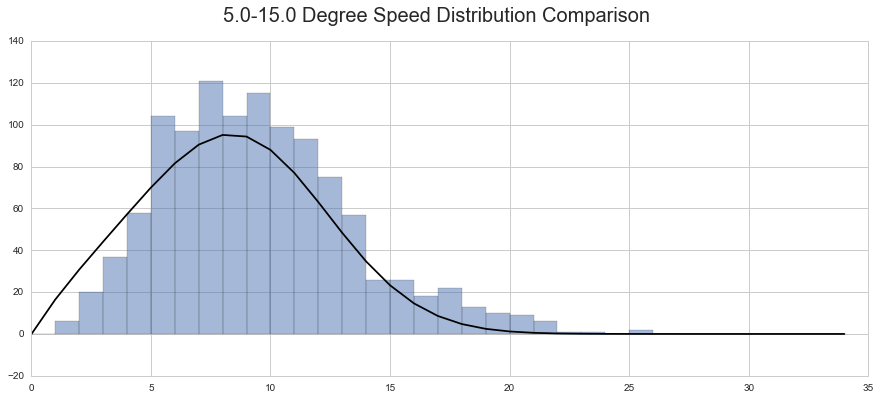

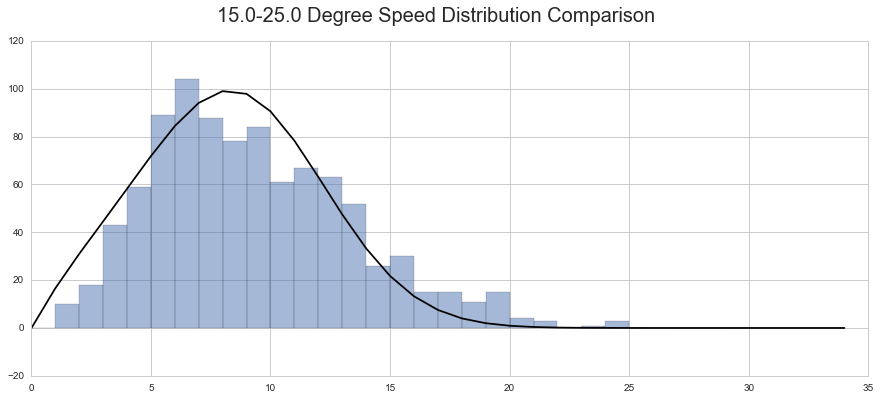

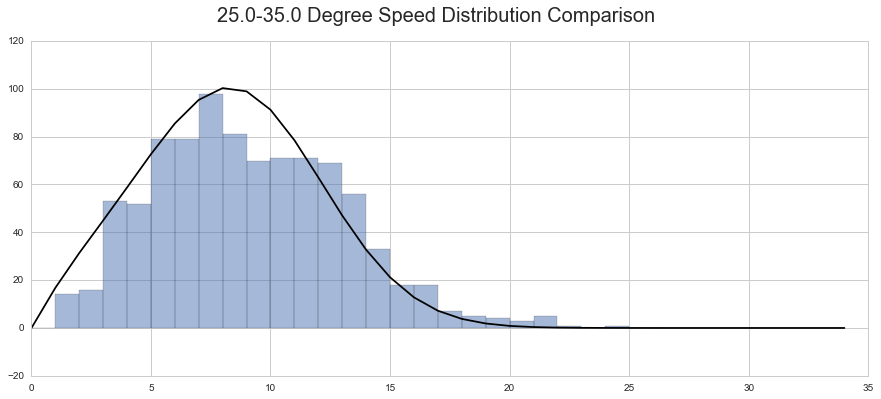

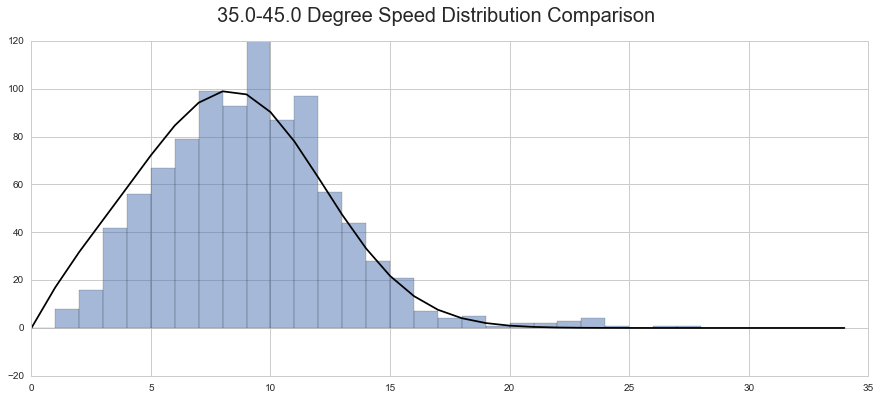

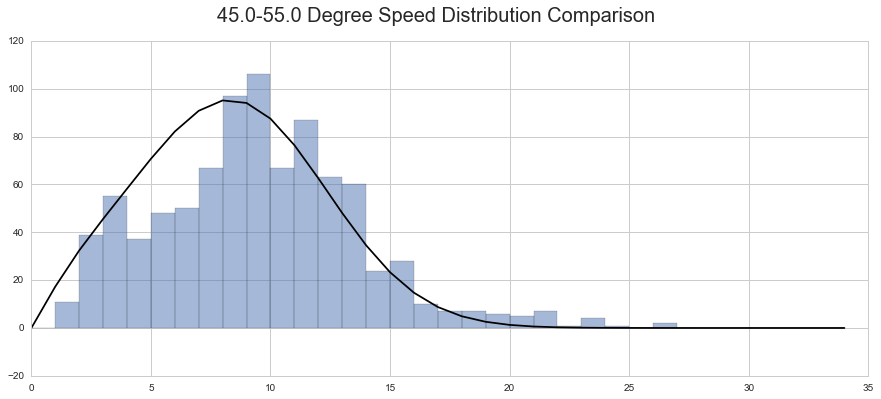

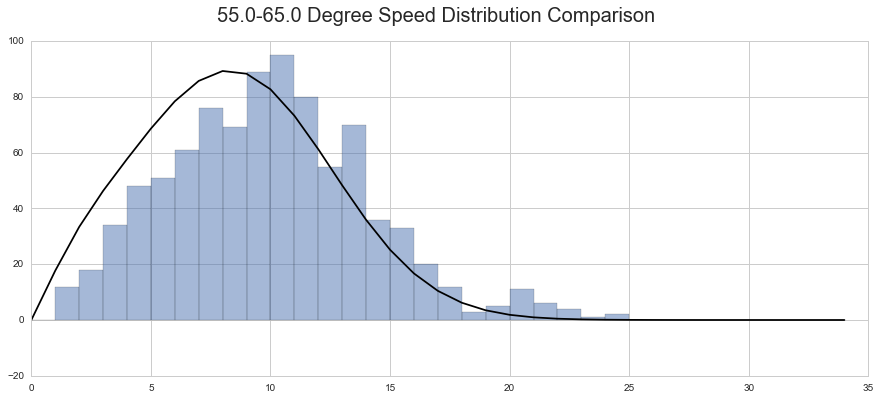

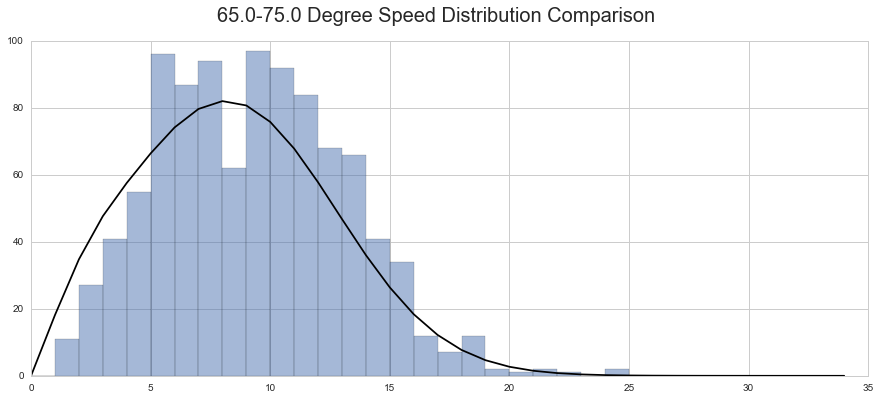

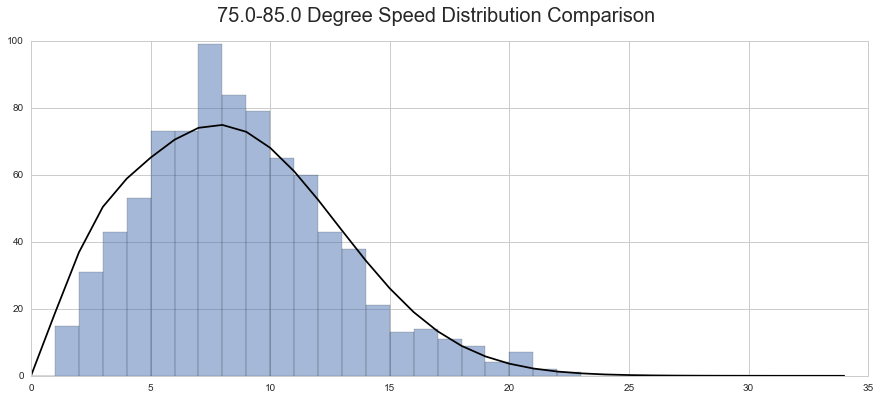

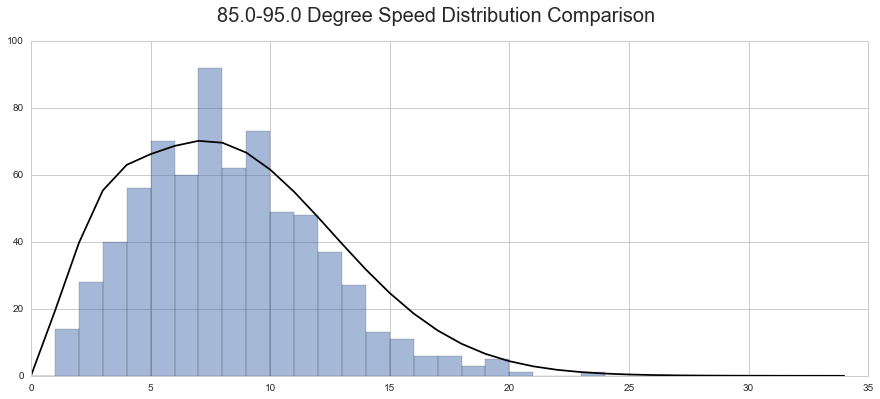

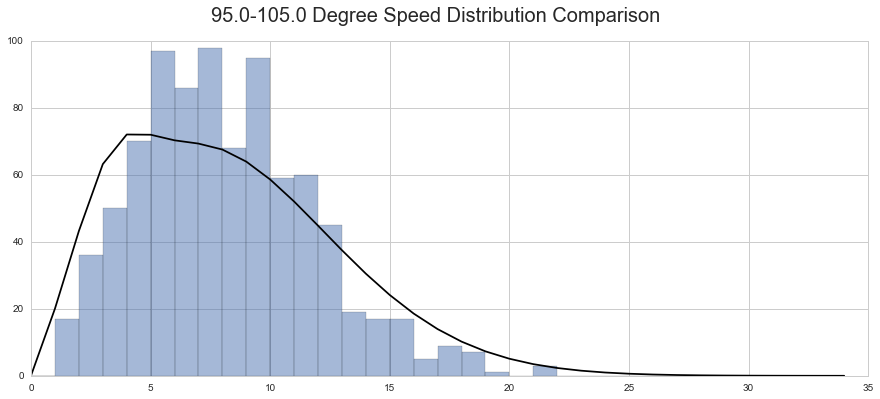

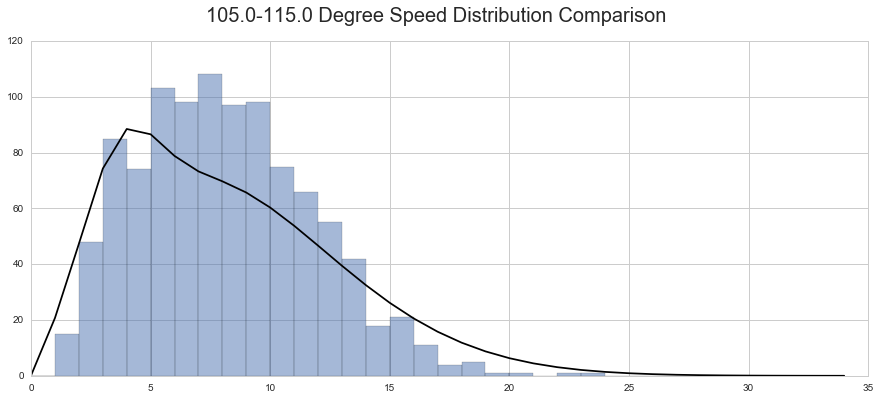

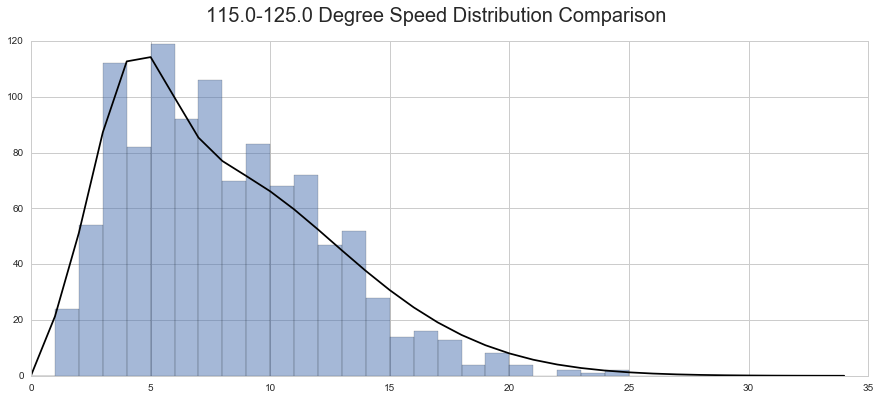

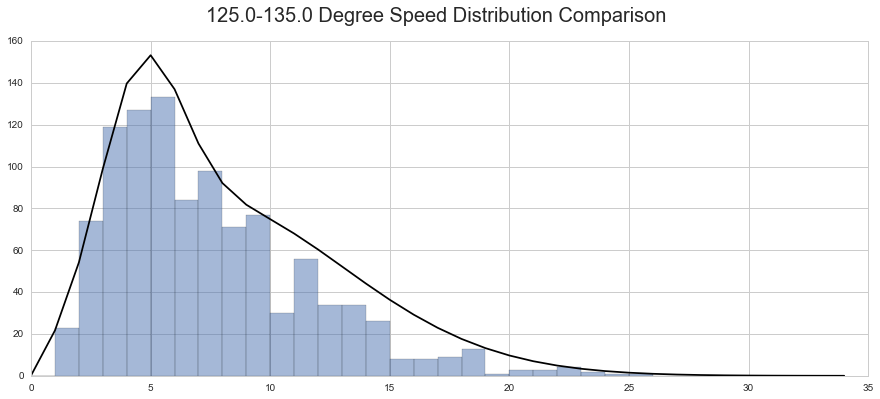

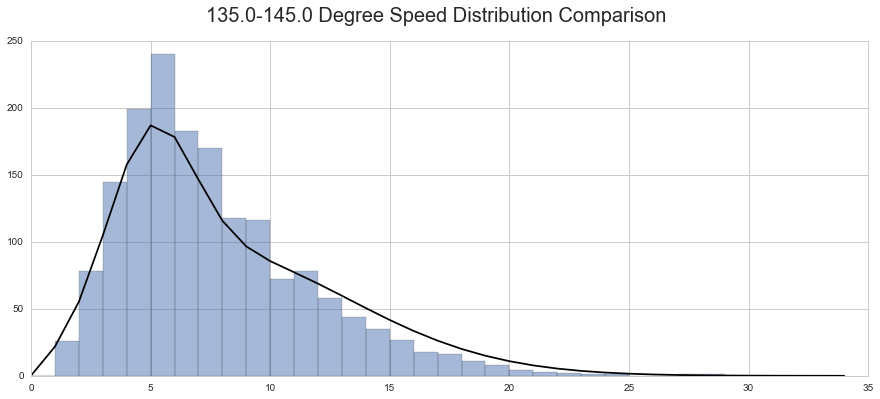

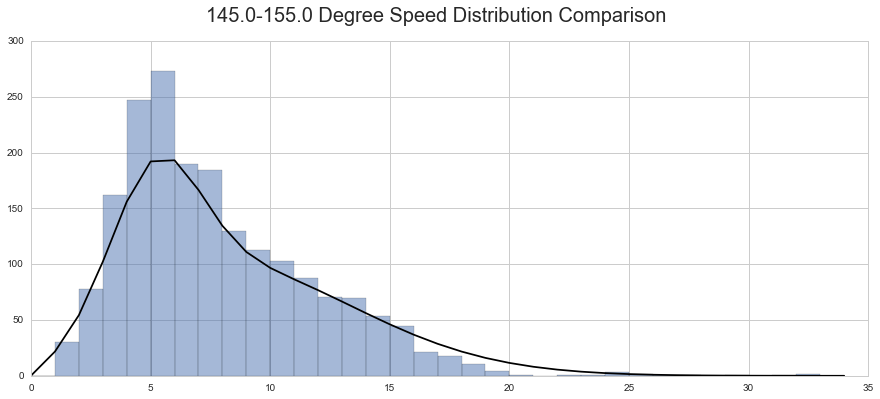

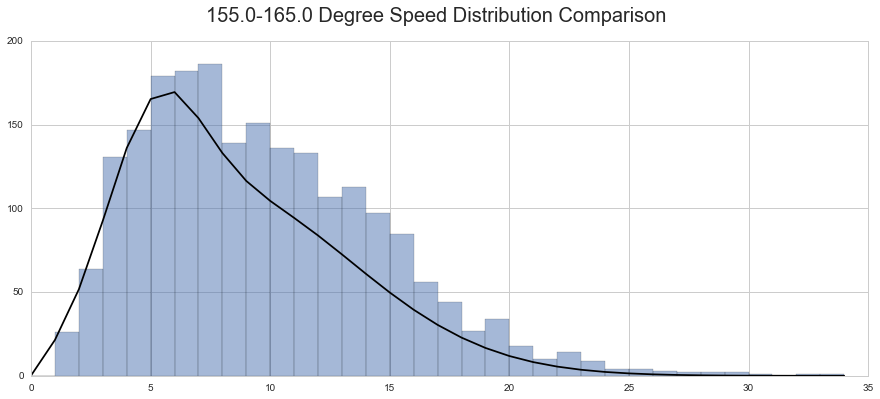

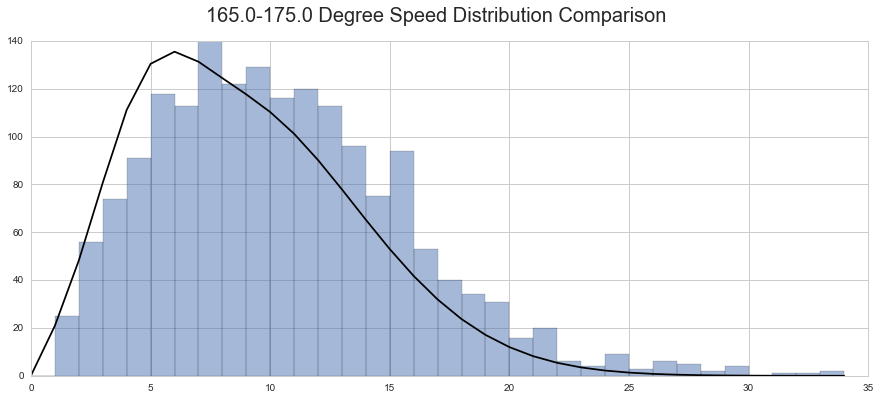

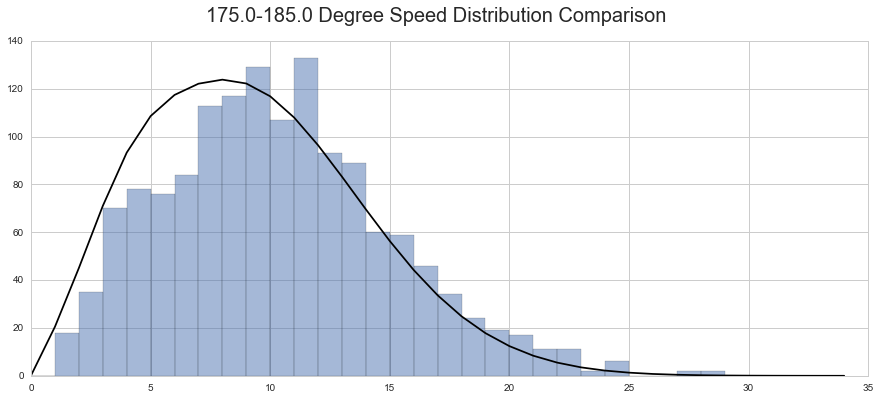

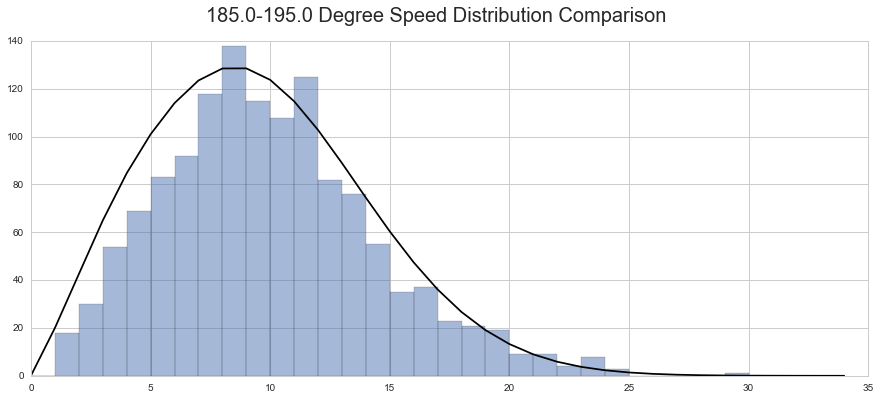

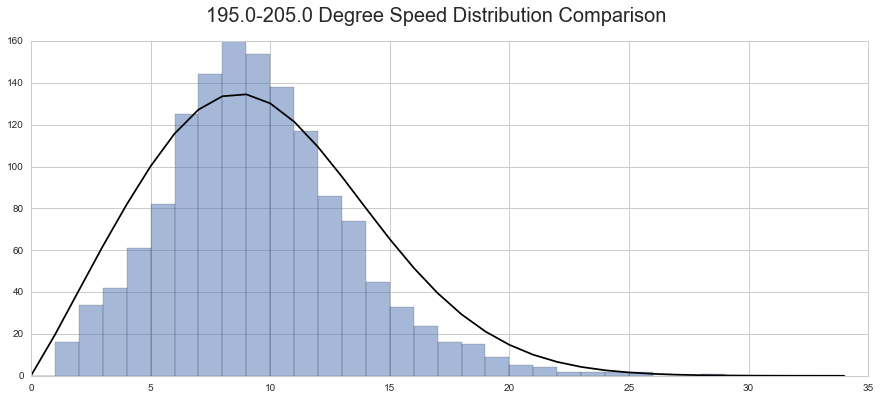

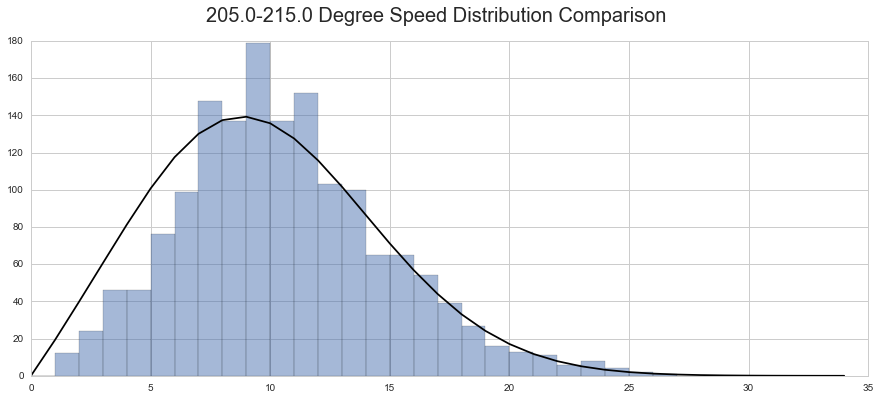

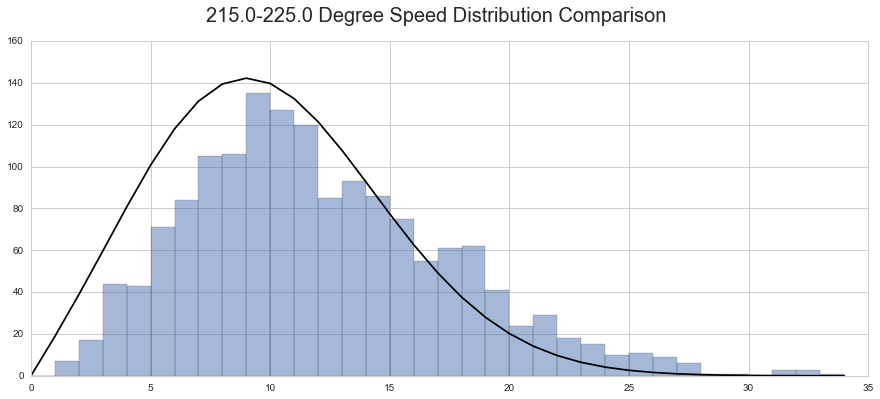

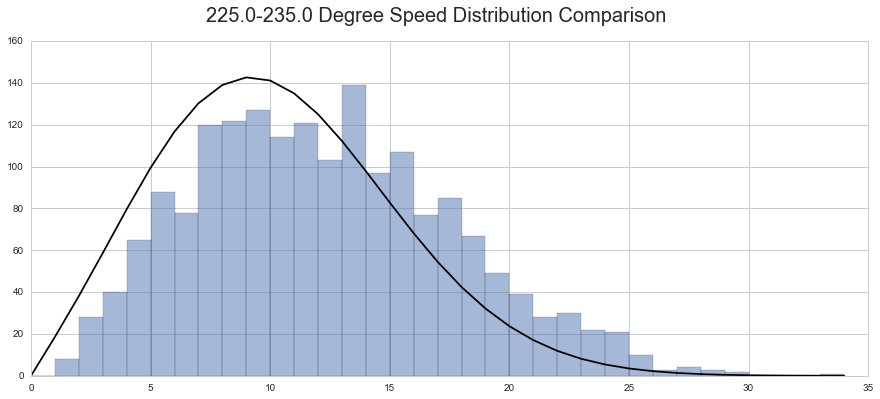

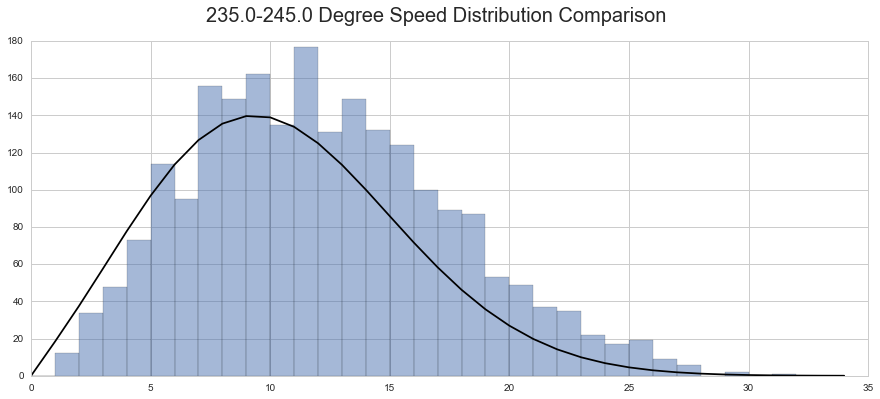

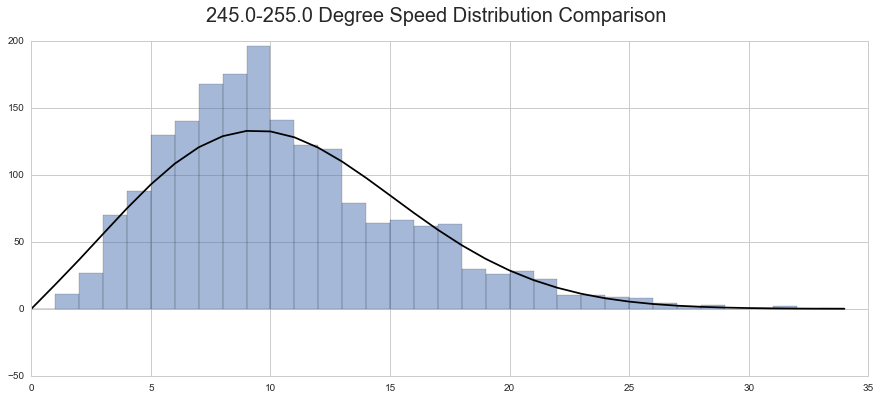

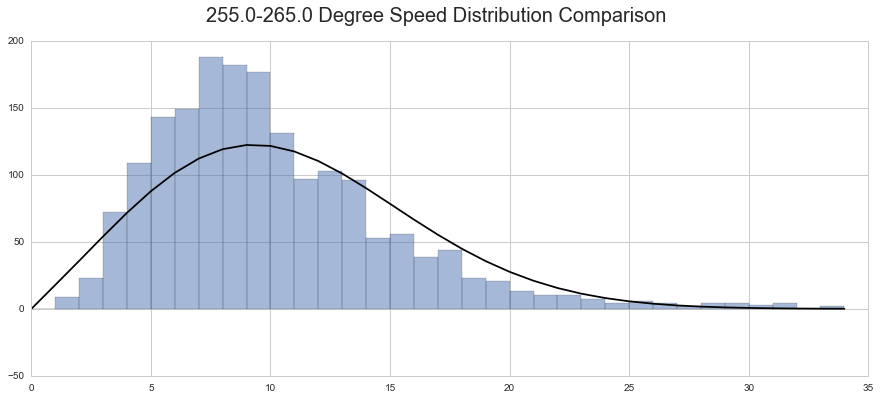

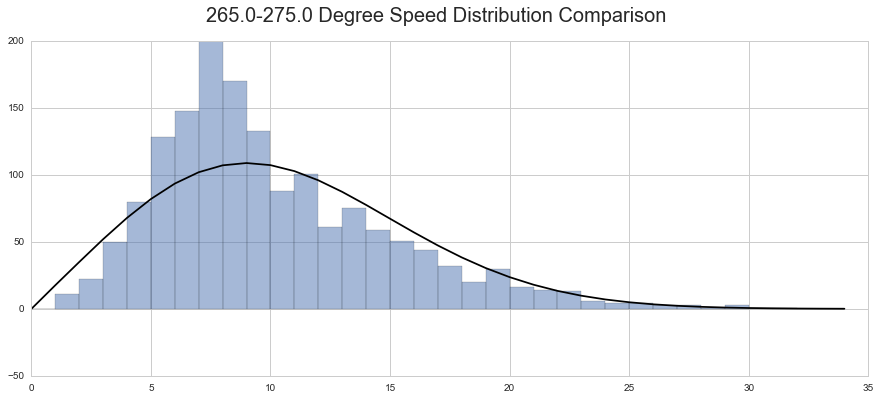

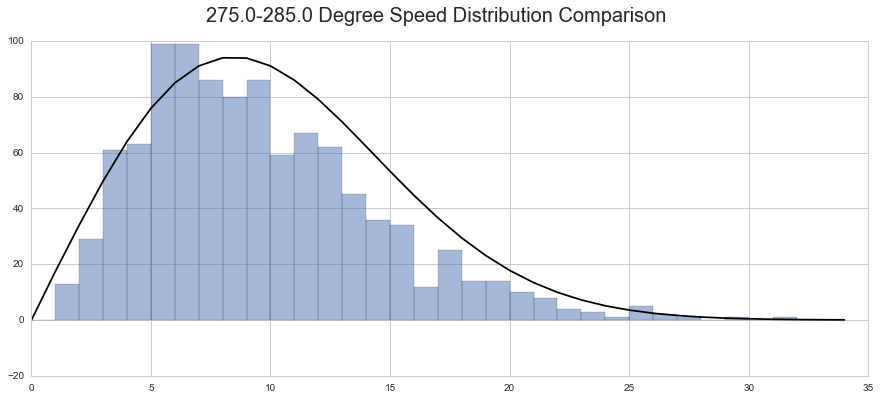

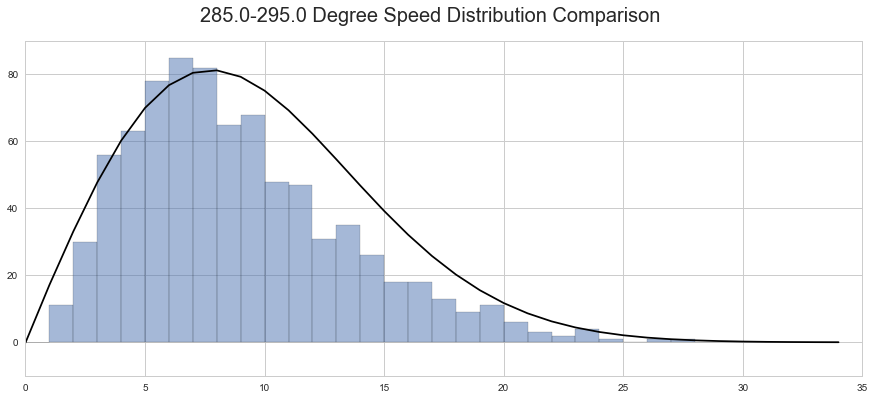

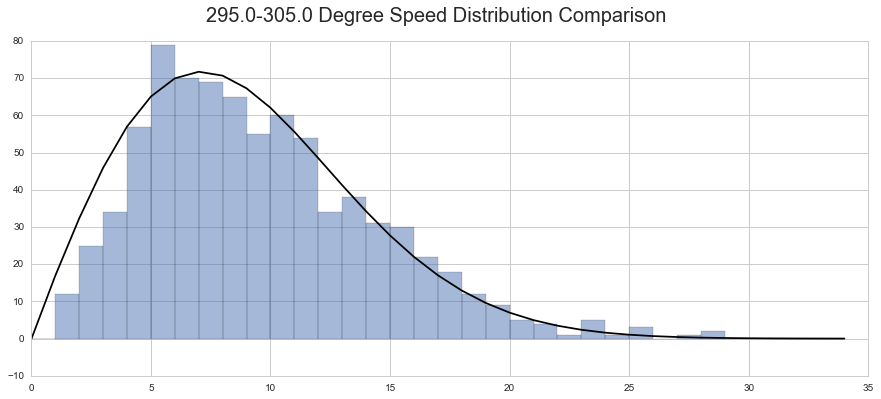

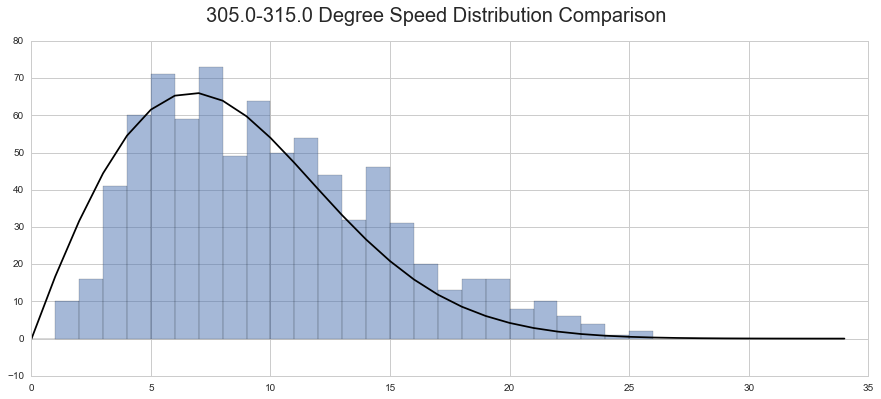

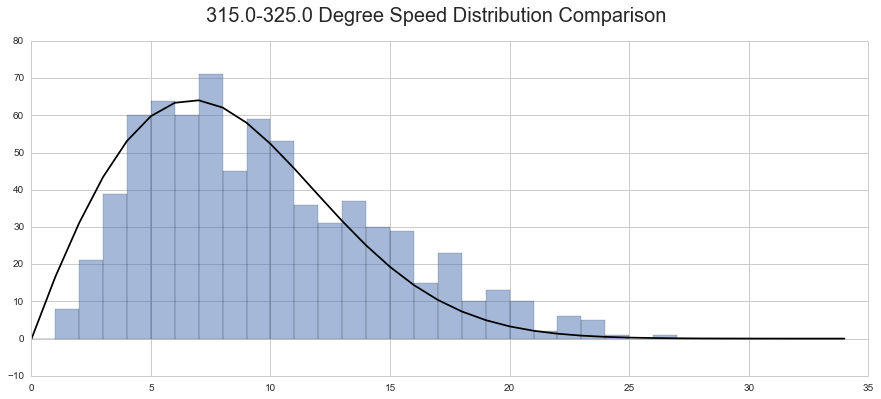

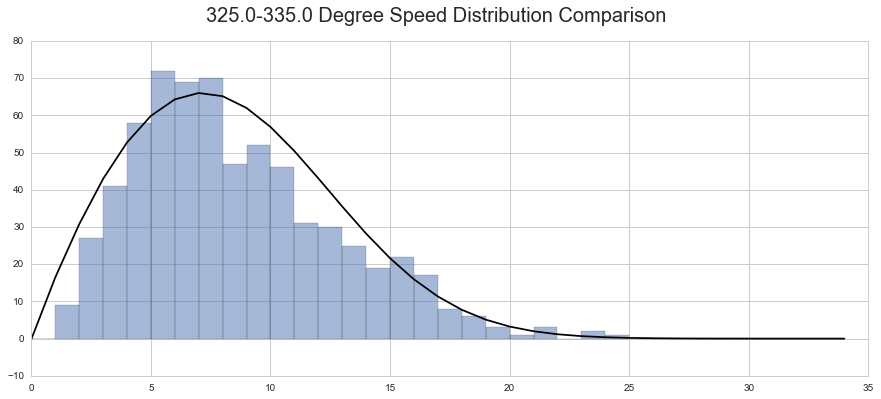

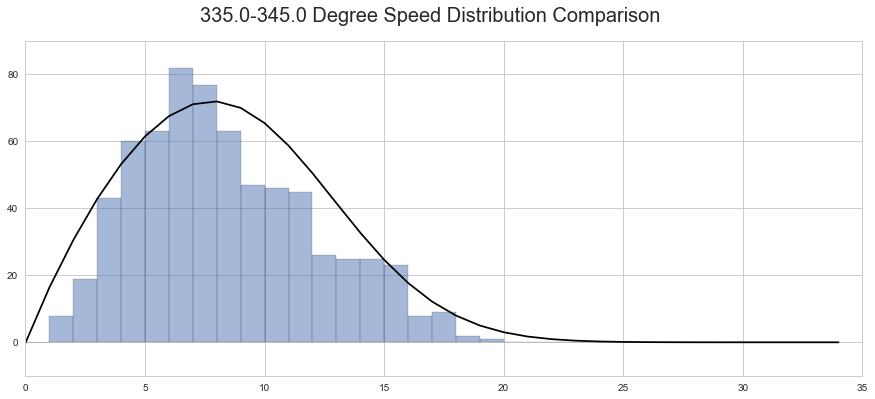

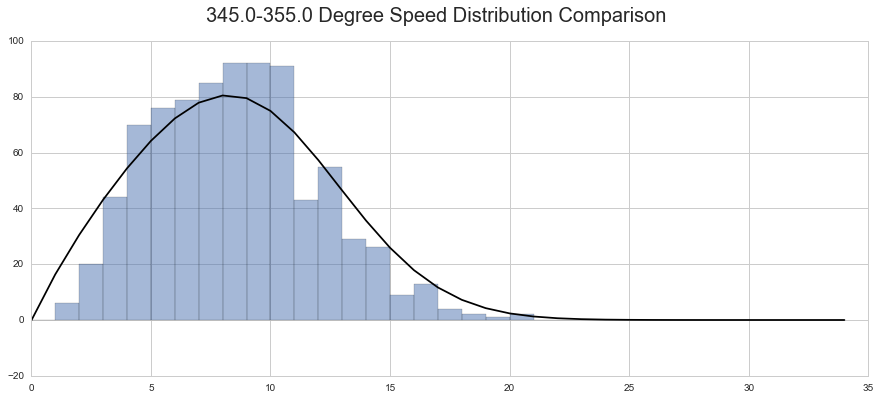

In [108]:
# Calculate Speed Distribution

angles = np.linspace(10,350, num=35)
for angle in angles:
    angle_in_arc = angle*np.pi/180
    angle_in_degree = angle
    
    # Number from observation
    start_angle, end_angle = angle_in_degree-5, angle_in_degree+5
    sub_df= df[(df['dir'] >= start_angle) & (df['dir'] <= end_angle)] 
    
    # Number from model
    x_vals = np.arange(0, 35, 1)
    y_vals_ =[integrate.nquad(f, [[x_val-0.5, x_val+0.5],[angle_in_arc-np.pi/36, angle_in_arc+np.pi/36]]) for x_val in x_vals]
    y_vals = np.array(zip(*y_vals_)[0])*len(df.speed)

    sub_df['speed'].hist(bins=x_vals, alpha=0.5,figsize=(15, 6))
    plt.plot(x_vals, y_vals,'-', color='black')
     
    title = str(start_angle) + '-' +str(end_angle)
    plt.suptitle(title+' Degree Speed Distribution Comparison', fontsize = 20)
    plt.show()

# Cross Validation, to check the number of ellipse to be fitted

In [109]:
# if "ciampino" in ipath: 
#     # For Ciampino
#     df = df[ (df['date'] >= 19950000) & (df['date'] < 20150000)]
# elif "marham" in ipath:
#     # For Marham
#     df = df[ (df['date'] >= 19950000) & (df['date'] < 20150000)]
# else: 
#     # For Tiree, non is stable
#     df = df[ (df['date'] >= 20050000) & (df['date'] < 20150000)]

In [135]:
from sklearn.cross_validation import train_test_split, KFold
    
def fit_gmm(df, number_of_gaussian = 3, printable = True):
    # 1. Create Input, speed_set
    sample = sub_speed_set = np.array(zip(df.x, df.y))
    points = fitting_range
    
    # 2. KDE + EM fitting
    kde = KernelDensity(bandwidth=1).fit(sample) 
    clf = mixture.GMM(n_components=number_of_gaussian, covariance_type='full')
    clf.fit(sample)
    kde_result = np.exp(kde.score_samples(points))
    gmm_em_result = read_gmm_em_result(clf, printable)
        
    # 3. GMM fitting
    x0 = gmm_em_result
    bonds = [(0., 0.99),(-30, 30),(-30, 30),(0., 30),(0., 30),(-0.99, 0.99)]*int(len(x0)/6)
 
    result = sp.optimize.minimize(
        lambda x0: GMM_fit_score(x0, kde_result),
        x0,
        bounds = bonds,
        constraints = cons,
        tol = 0.000000000001,
        options = {"maxiter": 500})  
    
    # 4. Returns
    gmm = group_gmm_param_from_gmm_param_array(result.x)       
    mixed_model_pdf = generate_gmm_pdf_from_grouped_gmm_param(gmm)
    gmm_pdf_result = mixed_model_pdf(points)
    
    return {
        'gmm' : gmm,
        'kde_result': kde_result,
        'gmm_pdf_result': gmm_pdf_result,
        'number_of_iteration': result.nit}

In [144]:
## 5-fold cross validation
CV_result_all =[]
for number_of_gaussian in xrange(1,6):
    print '  '
    print 'Number of gaussian', number_of_gaussian

    kf = KFold(len(df), n_folds=5, shuffle=True) # each number of gaussian, fit 4 times

    CV_result = []
    for train_index, test_index in kf:
        sub_df = df.iloc[train_index]
        sub_df_test = df.iloc[test_index]

        # 1. Train
        result = fit_gmm(sub_df, number_of_gaussian, False)
        gmm_pdf_result_train = result['gmm_pdf_result']

        # 2. Validate
        # GMM from Train - KDE from Test
        sample = np.array(zip(sub_df_test.x, sub_df_test.y))
        kde_test = KernelDensity(bandwidth=1).fit(sample) 
        kde_result_test = np.exp(kde.score_samples(points))

        gof_train = goodness_of_fit_summary(gmm_pdf_result_train, 
                                            kde_result, 
                                            count = len(sub_df))
        gof_test =  goodness_of_fit_summary(gmm_pdf_result_train, 
                                            kde_result_test, 
                                            count = len(sub_df_test))
        
        pp.pprint(gof_train)
        pp.pprint(gof_test)
        
        CV_result.append(gof_test)
        
    CV_result_all.append(CV_result)

  
Number of gaussian 1
{'Chi_square': 2835.3674597856002,
 'K_S': 0.05029482196934898,
 'MSE': 7.3741561732037447e-08,
 'RMSE / Mean': 0.46193590138914759,
 'RMSE / Mode': 0.050926962892235687,
 'R_square': 0.88494738072721291}
{'Chi_square': 708.90289308802267,
 'K_S': 0.05029482196934898,
 'MSE': 7.3741561732037447e-08,
 'RMSE / Mean': 0.46193590138914759,
 'RMSE / Mode': 0.050926962892235687,
 'R_square': 0.88494738072721291}
{'Chi_square': 2837.2689321765174,
 'K_S': 0.050392897738077314,
 'MSE': 7.4252401358569449e-08,
 'RMSE / Mean': 0.46353315463276407,
 'RMSE / Mode': 0.051103054978654042,
 'R_square': 0.88415036157437188}
{'Chi_square': 709.37830211283745,
 'K_S': 0.050392897738077314,
 'MSE': 7.4252401358569449e-08,
 'RMSE / Mean': 0.46353315463276407,
 'RMSE / Mode': 0.051103054978654042,
 'R_square': 0.88415036157437188}
{'Chi_square': 2830.6475408223041,
 'K_S': 0.048007341389216474,
 'MSE': 7.3505638465831772e-08,
 'RMSE / Mean': 0.46119636773569966,
 'RMSE / Mode': 0.05

[[-16.42018452   0.88465639]
 [-17.23187848   0.94877588]
 [-17.661332     0.96666002]
 [-18.35219381   0.98327358]
 [-18.73156595   0.98855753]]


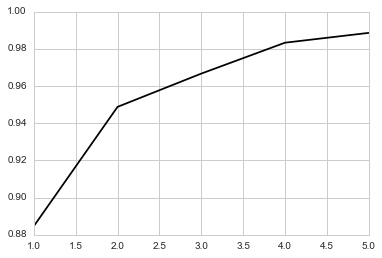

In [112]:
test = np.asarray(CV_result_all)
cv_means=test.mean(axis=1)
x = xrange(1,6)
y=cv_means[:,1]
plt.plot(x, y,'-', color='black')

print cv_means

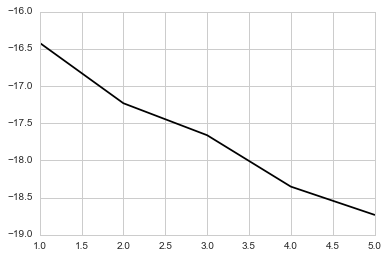

In [113]:
x = xrange(1,6)
y=cv_means[:,0]
plt.plot(x, y,'-', color='black')

In [114]:
sss

NameError: name 'sss' is not defined

# Time Shift, Loop Through Years to See the Difference

In [ ]:
# for start_time in xrange(19750000,20150000,50000):
#     end_time = start_time + 50000 
#     sub_df = df[ (df['date'] >= start_time) & (df['date'] < end_time)]
number_of_gaussian = 5

for i in xrange(1,20):
    sub_df = df.sample(frac=1, replace=True)
    
    # 1. Fitting
    plot_speed_and_angle_distribution(sub_df)
    result = fit_gmm(sub_df, number_of_gaussian)
    print 'MSE log', np.log(result['MSE']), ', R Square', result['R_square']
        
    fig = plt.figure(figsize=(15,8))
    X = Y = np.arange(-30, 31, 1)

    # 2. Plot KDE 
    Z = result['kde_result'].reshape(len(X),len(X)).T
    ax1 = fig.add_subplot(1,3,1)
    plot_2d_prob_density(X,Y,Z,ax1)
    
    # 3. Plot GMM Density
    mixed_model_pdf = generate_gmm_pdf_from_grouped_gmm_param(gmm)
    Z = generate_Z_from_X_Y(X,Y, mixed_model_pdf)
    ax2 = fig.add_subplot(1,3,2)
    plot_2d_prob_density(X,Y,Z,ax2)
    
    # 4. Plot Gmm Ellipse
    ax3 = fig.add_subplot(1,3,3)
    plot_gmm_ellipses(result['gmm'], ax3)